# PEC 4

**PEDRO LUIS VERGARA PEREZ**

# 1. DBPedia

En este notebook seguiremos utilizando las librerías python para trabajar con tripletas:

*   **`urllib`** para trabajar con URLs
*   **`datetime`** para formato e interpretación de fechas
*   **`rdflib`** para trabajar con tripletas RDF
*   **`rdflib-jsonld`** para usar JSON-LD  
*   **`SPARQLWrapper`** para ejecutar consultas SPARQL e importar los resultados en el notebook

In [61]:
!pip install -q rdflib
!pip install -q rdflib-jsonld
!pip install -q sparqlwrapper    #instalar SPARQLwrapper

In [4]:
import io
import urllib.request
import rdflib
import rdflib_jsonld
from rdflib import Graph, plugin
from SPARQLWrapper import SPARQLWrapper, JSON, XML, N3, RDF , POST, GET, POSTDIRECTLY, CSV
import warnings
warnings.filterwarnings ("ignore")

from IPython.display import HTML
import matplotlib.pyplot as plt
import math
import json 
import requests
import pandas as pd
import numpy as np
import unittest
from datetime import datetime

## 1.1 Crear un wrapper para SPARQL 


Para posibilitar la navegación en los datos como un grafo y hacer consultas usando el lenguaje SPARQL se necesita un endpoint SPARQL que es una dirección web que responde a peticiones.

In [5]:
# incluir funciones para tratar SPARQL

def create_sparql_client ( endpoint , result_format=JSON , query_method=POST , token=None ):
  ''' Crea un cliente SPARQL '''
  sparql = SPARQLWrapper(endpoint) # instanciar 
  if token:
    sparql.addCustomHttpHeader ("Authorization","Bearer {}".format(token))
  sparql.setMethod ( query_method )
  sparql.setReturnFormat ( result_format )
  if query_method == POST:
    sparql.setRequestMethod(POSTDIRECTLY)

  return sparql


def query_sparql ( sparql , prefix, query ):
  ''' Ejecuta una consulta SPARQL '''
  sparql.setQuery (prefix + query  )   # TODO: llamar a setQuery concatenando los prefijos y la consulta
  results = sparql.query()               
  if sparql.returnFormat == JSON:
        return results._convertJSON()
  return results.convert()


def print_results ( results, limit =''):
  ''' Imprime los resultados de una consulta SPARQL '''
  resdata = results["results"]["bindings"]
  if limit != '':
      resdata = results["results"]["bindings"]
  for result in resdata:
      for ans in result:
          print('{0}: {1}'.format(ans, result[ans]['value']))
      print()

 La función `query_sparql` obtiene resultados de la ejecución de una consulta SPARQL con un conjunto definido sobre un endpoint.

 A continuación con las funciones anteriormente definidas vamos a ejecutar una consulta de ejemplo:

In [9]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [10]:
# usar endpoint de la DBpedia
dbpedia_endpoint = 'https://dbpedia.org/sparql'


# crear cliente SPARQL 
sparql = create_sparql_client ( dbpedia_endpoint , result_format=JSON , query_method=POST , token=None )  # TODO : usar la funcion adecuada para crear un cliente SPARQL 

# definir prefijos
prefix = '''
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX dbr: <http://dbpedia.org/resource/>
    PREFIX dbp: <http://dbpedia.org/property/>
    PREFIX foaf: <http://xmlns.com/foaf/0.1/>
    PREFIX dct: <http://purl.org/dc/terms/>
    PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX dbo: <http://dbpedia.org/ontology/>
    PREFIX dbc: <http://dbpedia.org/resource/Category:>
    PREFIX geo: <http://www.w3.org/2003/01/geo/wgs84_pos#>
'''

# definir consulta
select_all_movies_query = """
    SELECT ?movie ?title
    WHERE {
       ?movie rdf:type dbo:Film;
              rdfs:label ?title .

       FILTER (langMatches(lang(?title), "en"))
    }
    LIMIT 5
"""
results = query_sparql ( sparql , prefix ,  select_all_movies_query ) # TODO: llamar a la funcion adecuada para ejecutar la consulta



print_results ( results, limit ='')

movie: http://dbpedia.org/resource/Aisa_Bhi_Hota_Hai
title: Aisa Bhi Hota Hai

movie: http://dbpedia.org/resource/Aisa_Hota_Hai
title: Aisa Hota Hai

movie: http://dbpedia.org/resource/Aisha_(upcoming_film)
title: Aisha (upcoming film)

movie: http://dbpedia.org/resource/Aithe
title: Aithe

movie: http://dbpedia.org/resource/Aiye
title: Aiye



## 1.2 Usando dataframes y otras funciones auxiliares


El resultado obtenido está en formato JSON que es un formato de intercambio muy útil aunque para nuestras necesidades es más conveniente poder tratar los resultados como un **dataframe**. Para esto usaremos las siguientes funciones:

In [11]:

def json2dataframe (results):
    ''' Genera un dataframe con los resultados de una consulta SPARQL  '''
    data = []
    for result in results["results"]["bindings"]:    # TODO: obtener resultados 
        tmp = {}
        for el in result:
            tmp[el] = result[el]['value']
        data.append(tmp)
    df = pd.DataFrame(data)
    return df

def dataframe_results(sparql, prefix, query ):
    ''' Ejecuta consulta y genera el dataframe '''
    return json2dataframe (query_sparql ( sparql , prefix, query ))  # TODO : llamar a la funcion para obtener el dataframe 


df = dataframe_results(sparql, prefix, select_all_movies_query)
df.head(5)

#assert isinstance(df, pd.DataFrame) == True
#assert len (df) == 5

,movie,title
0,http://dbpedia.org/resource/Aisa_Bhi_Hota_Hai,Aisa Bhi Hota Hai
1,http://dbpedia.org/resource/Aisa_Hota_Hai,Aisa Hota Hai
2,http://dbpedia.org/resource/Aisha_(upcoming_film),Aisha (upcoming film)
3,http://dbpedia.org/resource/Aithe,Aithe
4,http://dbpedia.org/resource/Aiye,Aiye


Como se puede observar, en los resultados aparecen URIs por lo que vamos a necesitamos unas funciones auxiliares que permitan convertir de URI a etiqueta y viceversa:

In [12]:
# Obtener el nombre asociado a una URI (en un idioma)
def get_label (uri, lang = 'en'):
  prefix = '''
      PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
      PREFIX foaf: <http://xmlns.com/foaf/0.1/>
      PREFIX dbo: <http://dbpedia.org/ontology/>
  '''
  query = '''
      SELECT ?Nombre
      WHERE { 
        <%s> rdf:type ?p;
               rdfs:label ?Nombre.
      FILTER (langMatches(lang(?Nombre), "%s"))

      }
  ''' % (uri,lang)

  df = dataframe_results(sparql, prefix, query)  # TODO 
  return df["Nombre"][0]

get_label('http://dbpedia.org/resource/Aisa_Hota_Hai')


'Aisa Hota Hai'

In [13]:
# Obtener la URI de una entidad a partir del nombre
def get_URI (name, lang = 'en'):
  prefix = '''
      PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
      PREFIX foaf: <http://xmlns.com/foaf/0.1/>
      PREFIX dbo: <http://dbpedia.org/ontology/>
  '''
  query = '''
      SELECT ?URI
      WHERE {
        ?URI foaf:name ?c.
        FILTER (langMatches(lang(?c), "%s"))
        FILTER (regex(?c,"%s"))
   
      } 

      '''  %(lang,name)
  df = dataframe_results(sparql, prefix, query)  # TODO 
  return df["URI"][0]

In [14]:
print ( get_label ( get_URI ("Antonio Banderas") ) )
print ( get_label ('http://dbpedia.org/resource/Charlie_Chaplin'))
print (get_URI ("Kevin Bacon"))
print (get_URI ("Cristiano Ronaldo"))

Antonio Banderas
Charlie Chaplin
http://dbpedia.org/resource/Kevin_Bacon
http://dbpedia.org/resource/2008_FIFA_Club_World_Cup_squads


Es posible preguntar por cualquiera de las propiedades que se almacenan de cada recurso. En esta ocasión vamos a preguntar por el lugar de nacimiento (`birthPlace`) de una persona, concretando con el nombre de la ciudad (en un solo idioma).

In [15]:
def birthPlace (person):
  person_uri=get_URI (person)
  prefix = '''
  PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
  PREFIX foaf: <http://xmlns.com/foaf/0.1/>
  PREFIX dbo: <http://dbpedia.org/ontology/>
  '''
  query = '''
    SELECT ?placeLabel
     WHERE {
         <%s> dbp:birthPlace ?placeLabel.
         FILTER (LANG(?placeLabel) = "en") 

    } ''' %(person_uri)

  df = dataframe_results(sparql, prefix, query)

  return df

birthPlace ("Kevin Bacon").head()

,placeLabel
0,"Philadelphia, Pennsylvania, U.S."


Usaremos esas funciones para obtener la filmografía de un actor.

In [16]:
def get_filmography (actor ):
  actor_uri = get_URI (actor)

  prefix = '''
  PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
  PREFIX foaf: <http://xmlns.com/foaf/0.1/>
  PREFIX dbo: <http://dbpedia.org/ontology/>
  '''
  query = '''
    SELECT ?film ?filmLabel
     WHERE {
       ?film rdf:type dbo:Film.
       ?film dbo:starring <%s>.
       ?film rdfs:label ?filmLabel.
       FILTER (LANG(?filmLabel) = "en")     

    }
  ''' %(actor_uri)

  df = dataframe_results(sparql, prefix, query)

  return df

get_filmography('Kevin Bacon').head(5)

,film,filmLabel
0,http://dbpedia.org/resource/R.I.P.D.,R.I.P.D.
1,http://dbpedia.org/resource/Enormous_Changes_a...,Enormous Changes at the Last Minute
2,http://dbpedia.org/resource/Patriots_Day_(film),Patriots Day (film)
3,http://dbpedia.org/resource/White_Water_Summer,White Water Summer
4,http://dbpedia.org/resource/You_Should_Have_Left,You Should Have Left


La siguiente consulta trata de recuperar listas de athletas que tiene la DbPedia junto con algunos datos como el nombre, fecha de nacimiento, altura, un resumen de su carrera y el país al que se asocian (si está disponible).

In [17]:
prefix = '''
    PREFIX foaf: <http://xmlns.com/foaf/0.1/>
    PREFIX dbo: <http://dbpedia.org/ontology/>
    PREFIX dbr: <http://dbpedia.org/resource/>
    PREFIX dbp: <http://dbpedia.org/property/>
'''

def get_query(limit, offset):
    return f'''
    SELECT DISTINCT ?player  ?name ?birthDate ?height ?abstract ?country
    WHERE{{
       ?player a dbo:Athlete;
            rdfs:label ?name;
            dbo:birthDate ?birthDate;
            dbo:height ?height;
            dbo:abstract ?abstract.
    OPTIONAL {{ ?player a dbo:Athlete;
              dbo:country ?c_ountry.
              ?c_ountry rdfs:label ?country.
    FILTER(LANG(?country) = "en").  # TODO 
              }} 
    FILTER(LANG(?name) = "en").  # TODO
    FILTER(LANG(?abstract) = "en").  # TODO 
    
    

    }}
     LIMIT {limit} OFFSET {offset}'''


athlete_df = dataframe_results(sparql, prefix , get_query (5000,0))
athlete_df.head(10)

,player,name,birthDate,height,abstract,country
0,http://dbpedia.org/resource/Jan-Michael_Gambill,Jan-Michael Gambill,1977-06-03,1.9,"Jan-Michael Charles Gambill (born June 3, 1977...",United States
1,http://dbpedia.org/resource/Al_Nesser,Al Nesser,1893-06-06,1.8796,"Alfred Louis Nesser (June 6, 1893 – March 1967...",NaN
2,http://dbpedia.org/resource/Alain_Nebie,Alain Nebie,1984-09-08,1.86,Alain Nebie (born 8 September 1984 in Burkina ...,NaN
3,http://dbpedia.org/resource/Hlynur_Bæringsson,Hlynur Bæringsson,1982-07-06,2.0066,Hlynur Elías Bæringsson (born 6 July 1982) is ...,NaN
4,http://dbpedia.org/resource/Hollie_Avil,Hollie Avil,1990-04-12,1.76,Hollie May Avil (born 12 April 1990) is an Eng...,NaN
5,http://dbpedia.org/resource/Horacio_Nava,Horacio Nava,1982-01-20,1.8,"Horacio Nava Meza (born January 20, 1982 in Ch...",NaN
6,http://dbpedia.org/resource/Horst_Bulau,Horst Bulau,1962-08-14,1.78,Horst Hardy Bulau (born 14 August 1962) is a C...,NaN
7,http://dbpedia.org/resource/Hussein_Dakik,Hussein Dakik,1988-11-10,1.8,Hussein Ali Dakik (Arabic: حسين علي دقيق‎; bor...,NaN
8,http://dbpedia.org/resource/Ian_Dalziel_(footb...,Ian Dalziel (footballer),1962-10-24,1.7272,Ian Dalziel (born 24 October 1962) is an Engli...,NaN
9,http://dbpedia.org/resource/Ian_Nicoll,Ian Nicoll,1946-10-02,1.79,Ian Nicoll (born 2 October 1946) is a former A...,NaN


Eliminar `http://dbpedia.org/resource/` de las columnas que lo tengan:

In [18]:
athlete_df["player"]=athlete_df["player"].apply(lambda x: x.split("http://dbpedia.org/resource/")[1])
athlete_df["player"]

0       Jan-Michael_Gambill
1                 Al_Nesser
2               Alain_Nebie
3         Hlynur_Bæringsson
4               Hollie_Avil
               ...         
4995           Jushin_Liger
4996          Jussi_Jokinen
4997           Jussi_Kujala
4998        Jussi_Markkanen
4999       Justyna_Jegiołka
Name: player, Length: 5000, dtype: object

Eliminar los duplicados:

In [19]:
len(athlete_df.player.unique()) == len (athlete_df)

athlete_df=athlete_df.drop_duplicates(subset=["player"])

athlete_df.head(5)


,player,name,birthDate,height,abstract,country
0,Jan-Michael_Gambill,Jan-Michael Gambill,1977-06-03,1.9,"Jan-Michael Charles Gambill (born June 3, 1977...",United States
1,Al_Nesser,Al Nesser,1893-06-06,1.8796,"Alfred Louis Nesser (June 6, 1893 – March 1967...",NaN
2,Alain_Nebie,Alain Nebie,1984-09-08,1.86,Alain Nebie (born 8 September 1984 in Burkina ...,NaN
3,Hlynur_Bæringsson,Hlynur Bæringsson,1982-07-06,2.0066,Hlynur Elías Bæringsson (born 6 July 1982) is ...,NaN
4,Hollie_Avil,Hollie Avil,1990-04-12,1.76,Hollie May Avil (born 12 April 1990) is an Eng...,NaN


In [20]:
len(athlete_df.player.unique()) == len (athlete_df)

True

Encontrar si hay valores 'extraños' como athletas de más de 2 metros y medio.

In [21]:
athlete_df["height"]=pd.to_numeric(athlete_df["height"])
athlete_df[athlete_df["height"]>2.5]


,player,name,birthDate,height,abstract,country
1264,Edison_Reshketa,Edison Reshketa,1999-06-02,3.82,Edison Reshketa (born 2 June 1999 in Shkoder) ...,NaN
1467,Alida_Marcovici,Alida Marcovici,1973-03-20,190.00,Alida Carmen Cioroianu Marcovici (born 20 Marc...,NaN
3064,Gulouchen_Karimova,Gulouchen Karimova,1979-09-16,183.00,Gulouchen Karimova (born 16 September 1979) is...,NaN
4004,Jolanda_Elshof,Jolanda Elshof,1975-08-05,184.00,Jolanda Elshof (born 5 August 1975) is a retir...,NaN


# WikiData (I)


**DBpedia** y **Wikidata** son dos proyectos de datos enlazados relacionados aunque diferentes. DBpedia se centra en generar datos abiertos enlazados a partir de documentos de la Wikipedia mientras que Wikidata se centra en crear (meta)datos abiertos enlazados para completar los documentos de la Wikipedia.


Ambos proyectos proporcionan acceso a sus respectivos datos a través de accesos (endpoint) SPARQL.

Supongamos la siguiente consulta:
```
SELECT ?person
WHERE {
?person wdt:P106 wd:Q5482740 .
}
```

Se define un **sujeto** de interés `?person` que será lo que aparezca como una columna de resultados. Las restricciones son que `wdt:P106` sea `wd:Q5482740` donde el prefijo `wdt:` significa que se va a especificar un atributo y `wd:`significa que se especifica un valor del atributo. `P106` establece una ocupación y `Q5482740` indica que es programador. Es decir, trata de localizar a las personas cuya ocupación es ser programador.





In [22]:
wikidata_endpoint = "https://query.wikidata.org/sparql"

wd_sparql = create_sparql_client ( wikidata_endpoint , result_format=JSON , query_method=POST , token=None )  # TODO : crear cliente sparql

q = '''SELECT ?person
        WHERE {
                ?person wdt:P106 wd:Q5482740 .
        }'''

df = dataframe_results (wd_sparql, '', q)
df.head(5)

,person
0,http://www.wikidata.org/entity/Q80
1,http://www.wikidata.org/entity/Q360
2,http://www.wikidata.org/entity/Q4864
3,http://www.wikidata.org/entity/Q5284
4,http://www.wikidata.org/entity/Q7259


Si observamos los resultados obtenemos una serie de códigos de personas, concretamente `wd:Q80` es [Tim Berners-Lee](https://www.wikidata.org/wiki/Q80), el inventor de la web. 


Como estos códigos no son muy intuitivos, WikiData dispone de una servicio de etiquetado que ayuda a traducir el código en un nombre. Para obtener el nombre de `person` sólo hay que añadir el atributo `label`: `personlabel` y añadirlo a la parte `SELECT` de la consulta.

También se puede añadir un filtro (`FILTER`) para obtener los resultados en un idioma concreto.


In [23]:
q = '''SELECT  ?person ?personLabel
WHERE {
  ?person wdt:P106 wd:Q5482740 .

  SERVICE wikibase:label { bd:serviceParam wikibase:language "en,es,ca". }
  
}'''

df = dataframe_results (wd_sparql, '', q)
df.head(3)

,person,personLabel
0,http://www.wikidata.org/entity/Q80,Tim Berners-Lee
1,http://www.wikidata.org/entity/Q360,Julian Assange
2,http://www.wikidata.org/entity/Q4864,Eugene Kaspersky


Tenemos los resultados pero se puede restringir más a aquellos que hayan tenido una aportación importante ( `wdt:P800`) a la industria del software:

In [24]:
q = '''
SELECT DISTINCT ?person ?personLabel ?workLabel
WHERE {
  ?person wdt:P106 wd:Q5482740 .
  
  ?person wdt:P800 ?work  # TODO : buscar el trabajo por el que son conocidos los programadores
  
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
  
}
'''

df = dataframe_results (wd_sparql, '', q)
df.head(5)

,person,personLabel,workLabel
0,http://www.wikidata.org/entity/Q454738,Chris Sawyer,Transport Tycoon
1,http://www.wikidata.org/entity/Q302817,Aaron Swartz,Reddit
2,http://www.wikidata.org/entity/Q242643,Naomi Novik,Victory of Eagles
3,http://www.wikidata.org/entity/Q483382,Steve Wozniak,Macintosh 128K
4,http://www.wikidata.org/entity/Q918650,Leonard Adleman,DNA computing


Aunque se observa que aparecen muchos resultados replicados varias veces pues si alguien tiene varias aportaciones importantes aparecerá varias veces. Por lo tanto, hay que agrupar todos las aportaciones en un solo atributo.

Para ello, las funciones de agrupamiento `GROUP BY` y `GROUP_CONCAT` pueden ser útiles. 

In [25]:
q = '''
SELECT DISTINCT ?person ?personLabel 
(GROUP_CONCAT(?workLabel;SEPARATOR=",") AS ?works)
WHERE {
  ?person wdt:P106 wd:Q5482740.
  ?person  rdfs:label   ?personLabel. 
  ?person wdt:P800 ?work.  # TODO
  ?work  rdfs:label ?workLabel .  # TODO    
  FILTER(LANG(?personLabel) = "en").
  FILTER(LANG(?workLabel) = "en").

}
GROUP BY ?person ?personLabel 
'''

df = dataframe_results (wd_sparql, '', q)
df.head(5)

,person,personLabel,works
0,http://www.wikidata.org/entity/Q93015,Adriaan van Wijngaarden,ALGOL
1,http://www.wikidata.org/entity/Q64850138,Max Howell,Homebrew
2,http://www.wikidata.org/entity/Q3351046,Olivier Fourdan,Xfce
3,http://www.wikidata.org/entity/Q64845926,Jordan Walke,React
4,http://www.wikidata.org/entity/Q17457,Donald Knuth,"Computer Modern,WEB,Metafont,CWEB,TeX,The Art ..."


Ahora es el momento de que les pongamos cara. Es posible obtener las fotografías de algunas de estas personas con `wdt:P18` para obtener una URL con una foto

In [26]:
q = '''
SELECT DISTINCT ?person ?personLabel 
(GROUP_CONCAT(?workLabel;SEPARATOR=",") AS ?works) ?image
WHERE {
  ?person wdt:P106 wd:Q5482740.
  ?person  rdfs:label   ?personLabel. 
  ?person wdt:P800 ?work.  # TODO
  ?work  rdfs:label ?workLabel .  # TODO 
  ?person   wdt:P18 ?image.
  FILTER(LANG(?personLabel) = "en").
  FILTER(LANG(?workLabel) = "en").

}
GROUP BY ?person ?personLabel ?image
'''

df = dataframe_results (wd_sparql, '', q)
df.head(5)

,person,personLabel,image,works
0,http://www.wikidata.org/entity/Q34253,Linus Torvalds,http://commons.wikimedia.org/wiki/Special:File...,"Subsurface,Linux kernel,Git"
1,http://www.wikidata.org/entity/Q483382,Steve Wozniak,http://commons.wikimedia.org/wiki/Special:File...,"Apple Inc.,Apple I,Breakout,Macintosh 128K,App..."
2,http://www.wikidata.org/entity/Q483382,Steve Wozniak,http://commons.wikimedia.org/wiki/Special:File...,"Apple Inc.,Apple I,Breakout,Macintosh 128K,App..."
3,http://www.wikidata.org/entity/Q318489,Bram Cohen,http://commons.wikimedia.org/wiki/Special:File...,"BitTorrent,Arroz al horno"
4,http://www.wikidata.org/entity/Q3309228,Ryan North,http://commons.wikimedia.org/wiki/Special:File...,"The Unbeatable Squirrel Girl,Dinosaur Comics"


Pudiendo visualizarlas dentro en el Dataframe con la siguiente función:

In [27]:
def image_formatter(im, width="80px"):
    return f'<img src="%s" width ="%s">' % (im, width)


HTML(df.dropna().head(5).to_html(formatters={'image': image_formatter}, # TODO: seleccionar columna de la imagen
                                 escape=False))


,person,personLabel,image,works
0,http://www.wikidata.org/entity/Q34253,Linus Torvalds,,"Subsurface,Linux kernel,Git"
1,http://www.wikidata.org/entity/Q483382,Steve Wozniak,,"Apple Inc.,Apple I,Breakout,Macintosh 128K,Apple II,US Festival"
2,http://www.wikidata.org/entity/Q483382,Steve Wozniak,,"Apple Inc.,Apple I,Breakout,Macintosh 128K,Apple II,US Festival"
3,http://www.wikidata.org/entity/Q318489,Bram Cohen,,"BitTorrent,Arroz al horno"
4,http://www.wikidata.org/entity/Q3309228,Ryan North,,"The Unbeatable Squirrel Girl,Dinosaur Comics"



Por último, de dónde proceden estas personas. Cada persona puede tener un atributo `country` (`wdt:P19`) y éste a su vez unas coordenadas (`wdt:P625`) con las que conseguir una latitud y longitud. 

In [28]:
q = '''
SELECT DISTINCT ?person ?personLabel ?lat ?lon
(GROUP_CONCAT(?workLabel;SEPARATOR=",") AS ?works) ?image
WHERE {
  ?person wdt:P106 wd:Q5482740.
  ?person  rdfs:label   ?personLabel. 
  ?person wdt:P800 ?work.  # TODO
  ?work  rdfs:label ?workLabel .  # TODO 
  ?person   wdt:P18 ?image.
  ?person wdt:P19 ?country.
  ?person wdt:P19 ?country.
  ?country p:P625 ?statement . 
  ?statement psv:P625 ?coordinate_node .
  ?coordinate_node wikibase:geoLatitude ?lat .
  ?coordinate_node wikibase:geoLongitude ?lon .
  FILTER(LANG(?personLabel) = "en").
  FILTER(LANG(?workLabel) = "en").

}
GROUP BY ?person ?personLabel ?image ?lat ?lon
'''

df = dataframe_results (wd_sparql, '', q)
df.head(10)

,person,personLabel,image,lat,lon,works
0,http://www.wikidata.org/entity/Q22708720,Terry A. Davis,http://commons.wikimedia.org/wiki/Special:File...,43.058055555556,-88.018333333333,TempleOS
1,http://www.wikidata.org/entity/Q7301768,Rebecca Heineman,http://commons.wikimedia.org/wiki/Special:File...,33.965555555556,-118.02444444444,"The Bard's Tale,Dragon Wars,Tass Times in Tone..."
2,http://www.wikidata.org/entity/Q95808667,Marco Ilardi,http://commons.wikimedia.org/wiki/Special:File...,40.833333333333,14.25,Main observations on genesis and morphological...
3,http://www.wikidata.org/entity/Q95808667,Marco Ilardi,http://commons.wikimedia.org/wiki/Special:File...,40.833333333333,14.25,Main observations on genesis and morphological...
4,http://www.wikidata.org/entity/Q95808667,Marco Ilardi,http://commons.wikimedia.org/wiki/Special:File...,40.833333333333,14.25,Main observations on genesis and morphological...
5,http://www.wikidata.org/entity/Q95808667,Marco Ilardi,http://commons.wikimedia.org/wiki/Special:File...,40.833333333333,14.25,Main observations on genesis and morphological...
6,http://www.wikidata.org/entity/Q92648,Brendan Eich,http://commons.wikimedia.org/wiki/Special:File...,40.441666666667,-80.0,JavaScript
7,http://www.wikidata.org/entity/Q302817,Aaron Swartz,http://commons.wikimedia.org/wiki/Special:File...,42.1825,-87.806944444444,"Reddit,RSS,Open Library"
8,http://www.wikidata.org/entity/Q4102656,Sergey Vakulenko,http://commons.wikimedia.org/wiki/Special:File...,50.6,32.4,DEMOS
9,http://www.wikidata.org/entity/Q242643,Naomi Novik,http://commons.wikimedia.org/wiki/Special:File...,40.712728,-74.006015,"Temeraire,Black Powder War,Victory of Eagles,C..."


Y ponerlos en un mapa

In [29]:
import folium

world_map = folium.Map(prefer_canvas=True)

for p in range ( df.shape[0]):
  lat = float(df["lat"][p])
  lon = float(df["lon"][p])
  name =df["personLabel"][p]
  folium.CircleMarker ( [lat , lon ], 
                       radius=1.5, 
                       line_color='#3186cc',
                       fill_color='#3186cc', 
                       fill=True,
                       tooltip =name).add_to(world_map)

world_map

# WikiData (II)


Ya hemos visto cómo se puede consultar WikiData y su sistema de identificadores. En esta ocasión hay que recuperar datos estadísticos de países de la Unión Europea. Para ello, hay que utilizar la propiedad `ser-miembro-de` (`member of`) (P463) con el objeto Unión Europea (Q458).

Resulta sencillo usar el servicio de etiquetado `SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }`que permite obtener los nombres de las entidades de manera más cómoda.

Además del nombre del país miembre de la UE vamos a recuperar algunos valores estadísticos: población (P1082) y superficie (P2046), si están disponibles.


Nota: La consulta debería devolver `Kingdom of the Netherlands` con item Q29999 en la lista de países europeos en vez de `Netherlands` (Q55) que forma parte de del país pero no es un país. De forma similar a como Inglaterra forma parte del Reino Unido.

In [30]:
q = '''
SELECT 
  ?country ?countryLabel ?population ?area 
WHERE {
  ?country wdt:P463 wd:Q458;  # TODO
   wdt:P1082 ?population; # TODO
   wdt:P2046 ?area.  # TODO

  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
'''

countries_df = dataframe_results (wd_sparql, '', q)
countries_df.tail(10)

,country,area,population,countryLabel
17,http://www.wikidata.org/entity/Q211,64589,1909000,Latvia
18,http://www.wikidata.org/entity/Q213,78866,10701777,Czech Republic
19,http://www.wikidata.org/entity/Q214,49035,5449270,Slovakia
20,http://www.wikidata.org/entity/Q215,20273,2066880,Slovenia
21,http://www.wikidata.org/entity/Q218,238397,19586539,Romania
22,http://www.wikidata.org/entity/Q219,110993.6,7000039,Bulgaria
23,http://www.wikidata.org/entity/Q224,56594,4105493,Croatia
24,http://www.wikidata.org/entity/Q229,9242.45,1141166,Cyprus
25,http://www.wikidata.org/entity/Q233,316,465292,Malta
26,http://www.wikidata.org/entity/Q29999,42201,17100715,Kingdom of the Netherlands


Analizar los tipos de datos que nos devuelve SPARQL y cómo se convierten en el DataFrame.

In [31]:
countries_df.dtypes

country         object
area            object
population      object
countryLabel    object
dtype: object

Convertir los tipos numéricos al formato más adecuado:

In [32]:
countries_df.area=countries_df.area.astype(float)
countries_df.population=countries_df.population.astype(int)
countries_df.head(5)

,country,area,population,countryLabel
0,http://www.wikidata.org/entity/Q27,70273.0,4761865,Ireland
1,http://www.wikidata.org/entity/Q28,93011.4,9769526,Hungary
2,http://www.wikidata.org/entity/Q29,505990.0,46733038,Spain
3,http://www.wikidata.org/entity/Q31,30528.0,11431406,Belgium
4,http://www.wikidata.org/entity/Q32,2586.4,626108,Luxembourg


In [33]:
countries_df.dtypes

country          object
area            float64
population        int32
countryLabel     object
dtype: object

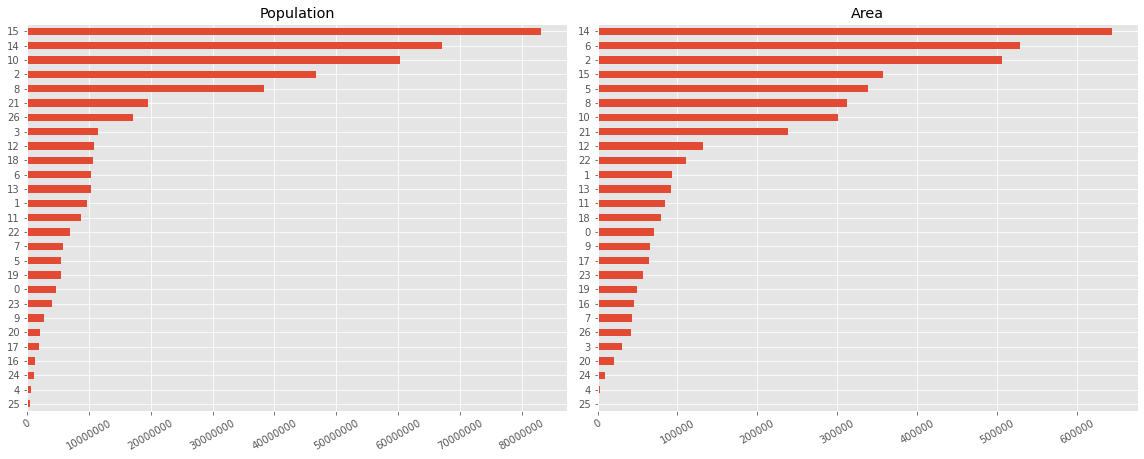

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(16, 12))
for i, label in enumerate(['population','area']):
    plt.subplot(2, 2, i + 1)
    df_plot = countries_df[label].sort_values().dropna()
    df_plot.plot(kind='barh', color='C0', ax=plt.gca());
    plt.ylabel('')
    plt.xticks(rotation=30)
    plt.title(label.capitalize())
    plt.ticklabel_format(style='plain', axis='x')
plt.tight_layout()

En esta ocasión la consulta es un poco más complicada. Se necesita obtener las capitales (P36) de las capitales de la UE y de la Asociación Europea de Libre Comercio (Q166546).

In [35]:
q = '''
SELECT  
  ?countryLabel ?capital_UELabel ?population 
WHERE {
  {?country  wdt:P463 wd:Q458.}UNION  {?country wdt:P463 wd:Q166546.}
  ?country  wdt:P36 ?capital_UE;
           wdt:P1082 ?population.

  SERVICE wikibase:label { 
    bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". 
  }
}
'''

capital_df = dataframe_results (wd_sparql, '', q)
capital_df.head(10)

,population,countryLabel,capital_UELabel
0,5391369,Norway,Oslo
1,8466017,Switzerland,Bern
2,357050,Iceland,Reykjavík
3,37922,Liechtenstein,Vaduz
4,4761865,Ireland,Dublin
5,9769526,Hungary,Budapest
6,46733038,Spain,Madrid
7,11431406,Belgium,City of Brussels
8,626108,Luxembourg,Luxembourg
9,5501043,Finland,Helsinki


Vamos a añadir obtener el nombre de los alcaldes actuales de esas capitales así como las coordenadas geográficas en las que se encuentran.

Para obtener las coordenadas geográficas se necesitan añadir las siguientes líneas a la consulta:


```
?capital p:P625/psv:P625 ?node.
?node wikibase:geoLatitude ?capital_lat.
?node wikibase:geoLongitude ?capital_lon.
```
Mediante p:P625/psv:P625 se pasa al valor del nodo de las coordenadas de la localización (P625)y con `wikibase:geoLatitude` y  `wikibase:geoLongitude` se recuperan la latitud y la longitud.



In [36]:
q = '''
SELECT  
  ?countryLabel ?capitalLabel ?population 
    ?capital_lon ?capital_lat ?mayorLabel 

WHERE {
  {?country  wdt:P463 wd:Q458.}UNION  {?country wdt:P463 wd:Q166546.}
  ?country  wdt:P36 ?capital;
           wdt:P1082 ?population.
  ?capital p:P625/psv:P625 ?node.
  ?node wikibase:geoLatitude ?capital_lat.
  ?node wikibase:geoLongitude ?capital_lon.
  ?capital p:P6 ?statement.
  ?statement ps:P6 ?mayor.
  FILTER NOT EXISTS {?statement pq:P582 ?end_date}

  SERVICE wikibase:label { 
    bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". 
  }
}
'''

capital_df = dataframe_results (wd_sparql, '', q)
capital_df.head(5)

,population,countryLabel,capitalLabel,mayorLabel,capital_lat,capital_lon
0,5449270,Slovakia,Bratislava,Matúš Vallo,48.144722222222,17.112777777778
1,11431406,Belgium,City of Brussels,Philippe Close,50.846666666667,4.3516666666667
2,17100715,Kingdom of the Netherlands,Amsterdam,Femke Halsema,52.383333333333,4.9
3,8466017,Switzerland,Bern,Alec von Graffenried,46.94798,7.44743
4,37922,Liechtenstein,Vaduz,Ewald Ospelt,47.139722222222,9.5219444444444


Convertir los datos numéricos al formato adecuado

In [37]:
capital_df.population=capital_df.population.astype(int)
capital_df.capital_lat=capital_df.capital_lat.astype(float)
capital_df.capital_lon=capital_df.capital_lon.astype(float)

capital_df.head(5)

,population,countryLabel,capitalLabel,mayorLabel,capital_lat,capital_lon
0,5449270,Slovakia,Bratislava,Matúš Vallo,48.144722,17.112778
1,11431406,Belgium,City of Brussels,Philippe Close,50.846667,4.351667
2,17100715,Kingdom of the Netherlands,Amsterdam,Femke Halsema,52.383333,4.900000
3,8466017,Switzerland,Bern,Alec von Graffenried,46.947980,7.447430
4,37922,Liechtenstein,Vaduz,Ewald Ospelt,47.139722,9.521944


Eliminar datos duplicados (si los hay)

In [38]:
len(capital_df['capitalLabel'].unique()) == len (capital_df)

False

In [39]:
capital_df=capital_df.drop_duplicates(subset=['capitalLabel'])
len(capital_df['capitalLabel'].unique()) == len (capital_df)

True

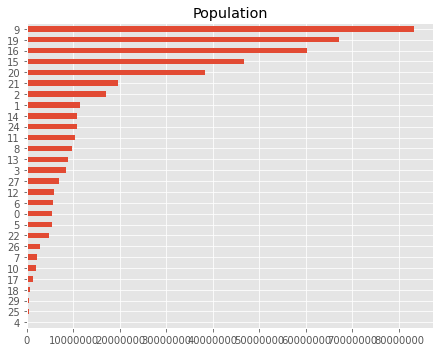

In [40]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
capital_df['population'].sort_values().plot(kind='barh', color='C0', title='Population')
plt.ylabel('')
plt.ticklabel_format(style='plain', axis='x')
plt.tight_layout()

In [41]:

capital_df.capital_lat.index=range(0,capital_df.shape[0])
capital_df.capital_lon.index=range(0,capital_df.shape[0])
capital_df.mayorLabel.index=range(0,capital_df.shape[0])

In [42]:
import folium

euro_map = folium.Map(location=[50,0],tiles="OpenStreetMap", zoom_start=4)

for p in range ( capital_df.shape[0]):
  lat = capital_df["capital_lat"][p]
  lon = capital_df["capital_lon"][p]
  name = capital_df.mayorLabel[p]
  folium.Marker ( [lat,lon ], # TODO
                       tooltip= name
                       ).add_to(euro_map)

euro_map

---

# 4. Grafos : Conexiones aéreas

En esta sección vamos a estudiar los grafos aplicados a las rutas aéreas. La idea es observar las rutas entre aeropuertos y encontrar vuelos entre ellos.

Vamos a utilizar dos conjuntos de datos para el análisis:


1.   **Aeropuertos**: Datos sobre los aeropuertos identificados por su código IATA
2.   **Rutas**: Datos sobre rutas aéreas con origen y destino aeropuertos y vuelos entre ellos.

Para obtener estos datos usaremos la URL `http://api.travelpayouts.com` que devuelve los datos en formato JSON. 




In [43]:
def get_airport_data():
    url = 'https://api.travelpayouts.com/data/en/airports.json'
    with urllib.request.urlopen(url) as url:
        airport_json = json.loads(url.read().decode("utf-8"))
    return airport_json

def get_routes_data():
    url = "http://api.travelpayouts.com/data/routes.json"
    with urllib.request.urlopen(url) as url:
        data = json.loads(url.read().decode("utf-8"))
    return data

Los datos de los aeropuertos son el código IATA, nombre, ciudad, etc.

Solamente se van a utilizar ciertos atributos de los aeropuertos.

In [44]:

columns = ['city_code', 'country_code','name','code']
# TODO : convertir a dataframe
airport_df =pd.DataFrame(get_airport_data())
airport_df.drop(airport_df.columns[[2,3,4,5,8]],axis="columns",inplace=True)
airport_df.columns=columns

airport_df.head(5)

,city_code,country_code,name,code
0,SGJ,PG,Sagarai,SGJ
1,ZBT,DK,Kolding Railway Station,ZBT
2,TIW,US,McChord AFB,TCM
3,KYI,AU,Yalata Mission,KYI
4,WAS,US,Washington Union Railway Station,ZWU


A continuación hay que filtrar los datos pues sólo vamos a analizar los aeropuertos de EE.UU. y de España:

In [45]:
airport_us = airport_df[airport_df.country_code=="US"]

airport_es = airport_df[airport_df.country_code=="ES"]
airport_es.head(5)

,city_code,country_code,name,code
34,HSK,ES,Huesca-Pirineos,HSK
42,XJR,ES,Lorca Bus Station,XJR
75,XJO,ES,Soria Bus Station,XJO
356,AEI,ES,Algeciras,AEI
369,AMR,ES,Arno,AMR


Se necesita unas variables que contengan la lista de códigos de los aeropuertos que usaremos más adelante.

In [46]:
airport_us_in =  airport_us.code.tolist()
airport_es_in =  airport_es.code.tolist()


Lo siguiente es cargar los datos de las rutas consistentes en códigos IATA de los aeropuertos, conexiones y detalles del vuelo, aunque sólo son de interés ciertas columnas.

In [47]:
columns = ['departure_airport_iata', 'arrival_airport_iata','flights']
routes_df =pd.DataFrame(get_routes_data())
routes_df.drop(routes_df.columns[[0,1,3,5,6,7]],axis="columns",inplace=True)
routes_df.columns=columns

airport_df.head(5)
# TODO: convertir a dataframe
routes_df.tail()

,departure_airport_iata,arrival_airport_iata,flights
64959,WIN,LRE,[SF3]
64960,WIN,TSV,[SF3]
64961,WYA,ADL,[SF3]
64962,LPA,TFN,[AT7]
64963,TFN,LPA,[AT7]


Se necesita una columna más que cuente el número de vuelos entre dos aeropuertos. En el JSON de rutas hay un array con `planes` y lo que se necesita es el número de elementos de ese array.

In [48]:
routes_df['flights'] = routes_df.flights=routes_df.flights.apply(lambda x: len(x))
routes_df.head(100)

,departure_airport_iata,arrival_airport_iata,flights
0,AER,DME,1
1,ASF,LED,1
2,CEK,DME,1
3,CEK,KZN,1
4,CEK,OVB,1
...,...,...,...
95,SCY,GYE,2
96,UIO,BOG,2
97,UIO,CUE,1
98,UIO,GYE,2


Para realizar el análisis hay que filtrar las rutas con origen y destino EE.UU. y con origen y destino España.

In [49]:
# TODO: Filtrar rutas con origen y destino USA
routes_us_f = routes_df[(routes_df.departure_airport_iata.apply(lambda x: x in airport_us_in ) & (routes_df.arrival_airport_iata.apply(lambda x: x in airport_us_in ))  ) ]

# TODO: Filtrar rutas con origen y destino España
routes_es_f = routes_df[(routes_df.departure_airport_iata.apply(lambda x: x in airport_es_in ) & (routes_df.arrival_airport_iata.apply(lambda x: x in airport_es_in) ))]

Hay que contar el número de rutas entre dos aeropuertos:

In [50]:
routes_us_g=routes_us_f.groupby("departure_airport_iata")["arrival_airport_iata"].describe().drop(["count","unique"],axis=1)
routes_es_g=routes_es_f.groupby("departure_airport_iata")["arrival_airport_iata"].describe().drop(["count","unique"],axis=1)
routes_es_g.head(5)



,top,freq
departure_airport_iata,,
ACE,BCN,5
AGP,SCQ,3
ALC,BCN,3
BCN,PMI,6
BIO,LPA,5


Como se puede ver existen bastantes rutas así que hay que realizar un filtro de los aeropuertos que tengan más de 5 conexiones para el caso de EE.UU. y 3 conexiones para el caso de España.

In [51]:
#TODO Filtrar las rutas que tengan más de 5 conexiones USA
routes_us_g = routes_us_g[routes_us_g.freq>5]
#TODO Filtrar las rutas que tengan más de 3 conexiones ESP
routes_es_g = routes_es_g[routes_es_g.freq>3]
routes_es_g.head(5)

,top,freq
departure_airport_iata,,
ACE,BCN,5
BCN,PMI,6
BIO,LPA,5
FUE,MAD,4
IBZ,BCN,4


In [52]:
def convert(df):
  lista=[]
  df.columns=[["arrival_airport_iata","routes"]]
  df.insert(0,"departure_airport_iata",df.index,)
  df.reset_index(drop=True,inplace=True)
  for i in range(len(df)):
    for j in range(df.iloc[i,2]):
      nueva_fila={"departure_airport_iata":df.iloc[i,0],"arrival_airport_iata":df.iloc[i,1],"routes":df.iloc[i,2]}
      lista.append(nueva_fila)
  return pd.DataFrame(lista)

In [53]:
routes_us_g=convert(routes_us_g)
routes_es_g=convert(routes_es_g)


Ahora ya está todo listo para el grafo donde los **aeropuertos** son los **nodos** y las **rutas** entre ellos son los **arcos**.

Usando los dataset que han sido preparados previamente, vamos a representar los grafos usando `networkx`y `matplotlib`.




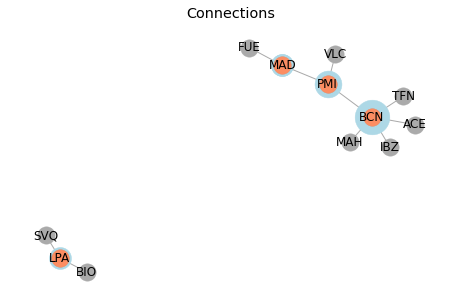

In [54]:
import networkx as nx

def draw_graph(data):
  plt.figure(figsize=(8, 5))

  g = nx.from_pandas_edgelist(data, 
                              source='departure_airport_iata', 
                              target='arrival_airport_iata')

  layout = nx.spring_layout(g, iterations=50)

  nx.draw_networkx_edges(g, layout, edge_color='#AAAAAA')

  # TODO: obtener un array de nodos de aeropuertos de destino
  dest = [edge for node,edge in g.edges()] # node in g.nodes()
  
  for i in range(len(dest)):
    size =g.degree(dest[i])*240
    nx.draw_networkx_nodes(g, layout, nodelist=[dest[i]], node_size=size, node_color='lightblue')

  # TODO: obtener un array de nodos de aeropuertos de origen
  orig = [node for node in g.nodes()] # node in g.nodes()

  nx.draw_networkx_nodes(g, layout, nodelist=orig, node_size=300, node_color='#AAAAAA')
  high_degree_orig = [node for node in g.nodes() if node in data.departure_airport_iata.unique() and g.degree(node) > 1]

  nx.draw_networkx_nodes(g, layout, nodelist=high_degree_orig, node_size=300, node_color='#fc8d62')

  orig_dict = dict(zip(orig, orig))
  nx.draw_networkx_labels(g, layout, labels=orig_dict)
  
  plt.axis('off')
  plt.title("Connections")  
  plt.show()


draw_graph(routes_es_g)

Los nodos en azul son conexiones de origen y en naranja las conexiones de destino. El tamaño de los círculos indica el número de conexiones con origen y destino al nodo. Según el grafo anterior deberían observarse los principales aeropuertos españoles.

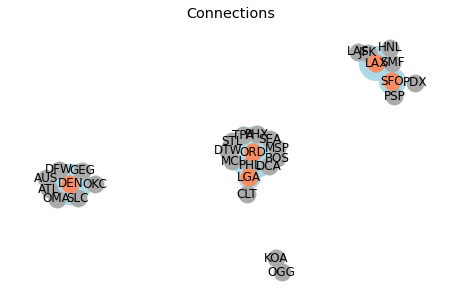

In [55]:
draw_graph(routes_us_g)

En el caso de EE.UU. se pueden ver los principales aeropuertos: ORD, DEN y LAX. 

A continuación vamos a definir diferentes métricas de centralidad que representan los factores de proximidad entre nodos en un grafo.

La primera es el **grado de centralidad** que mide para cada nodo del grafo el número de conexiones con origen y destino a ese nodo:

$ C_{D} (i) = \sum_{ j=1 \\ (i \neq j)}^{N}x_{ij} $


La librería `networkx` dispone de una función para calcular el grado de centralidad de una grafo: `degree_centrality`.




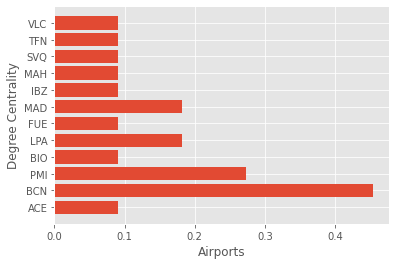

In [56]:
def show_centrality(data):

  g = nx.from_pandas_edgelist(data, 
                              source='departure_airport_iata', 
                              target='arrival_airport_iata')
  # TODO: calcular 
  deg_cen = nx.degree_centrality(g)
  data_deg_cen = pd.DataFrame(deg_cen.items())
  data_deg_cen = data_deg_cen[data_deg_cen[1] > 0.05]
  # plot the histogram 
  plt.barh(data_deg_cen[0], data_deg_cen[1])
  plt.xlabel('Airports')
  plt.ylabel('Degree Centrality')
  plt.show()

show_centrality(routes_es_g)


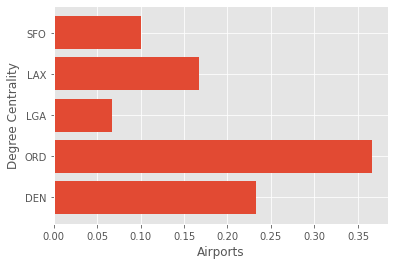

In [57]:
show_centrality(routes_us_g)

La otra métrica que vamos a usar es la **centralidad de intermediación** (betweenness centrality) que determina el número de rutas que pasan a través de un nodo en una red. Significa que puede haber un número de conexiones entre dos nodos a través de un nodo específico.

$ C_{B} (i) = \sum_{ j=1 \\ (i \neq j)}^{N}  \sum_{ k=1 \\ (k \neq i)}^{j-1} \frac {g_{jk}(i)}{g_{jk}} $

También la librería `networkx` dispone de una función para calcular el grado de centralidad de una grafo: `betweenness_centrality`.



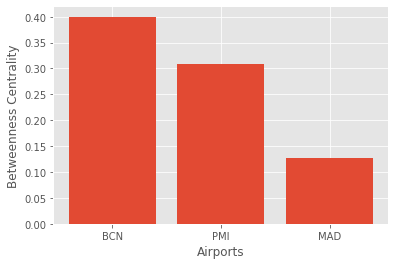

In [58]:
def show_bet_centrality(data):
  g = nx.from_pandas_edgelist(data, source='departure_airport_iata', target='arrival_airport_iata')
  bet_cen =  nx.betweenness_centrality(g)
  data_bet_cen = pd.DataFrame(bet_cen.items())
  # print(data)
  data_bet_cen = data_bet_cen[data_bet_cen[1] > 0.05]
  plt.bar(data_bet_cen[0], data_bet_cen[1])
  plt.xlabel('Airports')
  plt.ylabel('Betweenness Centrality')
  plt.show()

show_bet_centrality( routes_es_g )

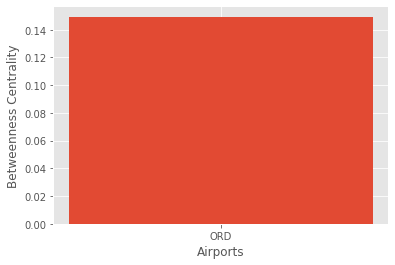

In [59]:
show_bet_centrality( routes_us_g )

Estos aeropuertos con más conexiones a través de ellos son los que más opciones ofrecen para las conexiones con otros destinos.

## 4.1. Consulta de API: vuelos en tiempo real


En esta sección vamos a trabajar con datos sobre rutas aéreas, compañías aéreas y aeropuertos.

Los datos en tiempo real los vamos obtener de la [API OpenSky](https://opensky-network.org/). Lo primero será cargar las librerías necesarias:

In [60]:
!git clone https://github.com/openskynetwork/opensky-api.git
!pip install -e ./opensky-api/python

Cloning into 'opensky-api'...
"pip" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [61]:
import sys
sys.path.append('./opensky-api/python')

Con esta API vamos a obtener los datos de los vuelos que están en este instante sobrevolando la península ibérica:

In [62]:
from opensky_api import OpenSkyApi

import time
from datetime import datetime, timedelta

api = OpenSkyApi()

t = int(time.time())

bboxSpain = [27.4335426 ,	43.9933088 ,	-18.3936845, 	4.5918885]

states = api.get_states(time_secs= t, bbox=bboxSpain)
for s in states.states[0:10]:
  print("(%r, %r, %r, %r)" % (s.latitude,s.longitude, s.velocity, s.callsign ))

(29.8476, -15.0178, 235.36, 'TAP1543 ')
(40.4818, -7.4893, 237.79, 'DLH36J  ')
(40.2941, -3.5103, 229.88, 'DLH22P  ')
(34.6574, -6.9388, 225.67, 'WZZ5514 ')
(41.3031, 2.0919, 38.07, 'WZZ1145 ')
(37.9385, -2.5495, 218.36, 'WZZ2832 ')
(41.3589, -7.246, 221.42, 'WZZ1789 ')
(36.1328, 1.0246, 224.09, 'WZZ8308 ')
(42.8493, -7.6958, 229.03, 'TAP1335 ')
(42.8768, -0.2194, 261.87, 'DLH506  ')


Y esto lo vamos a representar en un mapa:

In [63]:
import folium

world_map = folium.Map(location =[40.416775, -3.7388], tiles='stamenterrain', zoom_start=6,prefer_canvas=True)

for s in states.states[0:100]:
  try:
    folium.Marker([s.latitude ,s.longitude ], # TODO: lat lon
                tooltip=s.callsign + ' (' + s.origin_country + ')',
                icon=folium.Icon(icon='plane', color='green')
              ).add_to(world_map)
  except:
    pass
world_map

# Parte 5. Grafos de conocimiento


Un **[grafo de conocimiento](https://en.wikipedia.org/wiki/Knowledge_Graph)** consiste en una colección de información interrelacionada, normalmente limitada a un dominio específico y gestionado como un grafo. La unidad básica de un grafo de conocimiento es una tripleta *subjeto-predicado-objeto*, que en ocasiones se denota por (*head*, *relation*, *tail*) o más conciso (h, r, t).


El grafo de conocimiento representa el conocimiento mediante *entidades* (como personas, localizaciones, organizaciones, incluso eventos) y sus relaciones. Cada tripleta define una conexión entre dos entidades en el grafo. Una ontología define las relaciones y entidades aceptables en el grafo.


Veamos un ejemplo: Si un nodoA = `Putin` y el nodoB = `Rusia`, entonces es bastante probable que el arco que los une sea `presidenteDe`. Un nodo o entidad puede tener múltiples relaciones, así Putin no sólo es presidente de Rusia también trabajó para el servicio secreto de la Unión Soviética o KGB.

La idea es la misma que la web semántica: hacer que toda la información en internet esté conectada y sea entendible por los ordenadores mediante estándares como `RDF` o `schema.org`.

Es posible construir un grafo de conocimiento a partir de texto, pero para ello hay que hacer que una máquina "entienda" el lenguaje natural. Esto se puede aproximar mediante las técnicas de **Procesamiento del Lenguaje Natural** (NLP por sus siglas en inglés) como segmentación de sentencias, análisis de dependencias, etiquetado del discurso y reconocimiento de entidades. Veremos una introdución a todo esto.

In [64]:
import re
import nltk
from nltk.tokenize import sent_tokenize
import spacy
import networkx as nx
import matplotlib.pyplot as plt


ModuleNotFoundError: No module named 'spacy'

## 5.1 Extracción de entidades

El primer paso para construir un grafo de conocimiento es separar el texto de los documentos o artículos en sentencias u oraciones. De todas ellas nos vamos a centrar en aquellas que tienen exactamente 1 sujeto y 1 objeto.

Cada sentencia se divide en tokens, cuando `spaCy` procesa el texto, añade un tag **`dep_`** a cada palabra indicando la función : sujeto, objeto, etc. 


In [ ]:
nlp=spacy.load("en_core_web_sm")
doc = nlp("London is the capital and largest city of England and the United Kingdom.")

for token in doc:
  print(token.text, "...", token.dep_)

London ... nsubj
is ... ROOT
the ... det
capital ... attr
and ... cc
largest ... amod
city ... conj
of ... prep
England ... pobj
and ... cc
the ... det
United ... compound
Kingdom ... conj
. ... punct


El sujeto (`nsubj`) en esta oración según el analizador de dependencias es `London`, aunque las entidades se pueden encontrar modificadas con `amond` o formar composiciones `compound`. El objeto de la sentencia es `England` (`pobj`) junto con `United Kingdom`. Por tanto, habría que extraer tanto el sujeto como el objeto junto con sus modificadores. Es conveniente ver la documentación de SpaCy para ver los diferentes tipos de tokens.



Existe sin embargo un API (Wikifier API) que permite etiquetar entidades en un texto. Como ejemplo de lo que puede hacer la API Wikifier, supongamos el siguiente texto sobre [Elon Musk](https://en.wikipedia.org/wiki/Elon_Musk) , extraído y modificado de la WikiPedia.

In [ ]:
EM_text = """
Elon Musk is a business magnate, industrial designer, and engineer. 
Elon Musk is the founder, CEO, CTO, and chief designer of SpaceX. 
Elon Musk is also early investor, CEO, and product architect of Tesla, Inc. 
Elon Musk is also the founder of The Boring Company and the co-founder of Neuralink. 
A centibillionaire, Musk became the richest person in the world in January 2021, with an estimated net worth of $185 billion at the time, surpassing Jeff Bezos. 
Musk was born to a Canadian mother and South African father and raised in Pretoria, South Africa. 
Elon Musk briefly attended the University of Pretoria before moving to Canada aged 17 to attend Queen's University. 
Elon Musk transferred to the University of Pennsylvania two years later, where Elon Musk received dual bachelor's degrees in economics and physics. 
Elon Musk moved to California in 1995 to attend Stanford University, but decided instead to pursue a business career. 
Elon Musk went on co-founding a web software company Zip2 with Elon Musk brother Kimbal Musk.
"""

Definimos una función que nos permita acceder a Wikifier API.

In [ ]:
import urllib
from string import punctuation
import nltk
import json

ENTITY_TYPES = ["human", "person", "company", "enterprise", "business", "geographic region","brother",
                "human settlement", "geographic entity", "territorial entity type", "organization"]


def wikifier(text, lang="en", threshold=0.8):
    """Function that fetches entity linking results from wikifier.com API"""
    # URL.
    data = urllib.parse.urlencode([
        ("text", text), ("lang", lang),
        ("userKey", "icrogulbfeovyizvqttnfhjcixksdw"),
        ("pageRankSqThreshold", "%g" % threshold), 
        ("applyPageRankSqThreshold", "true"),
        ("nTopDfValuesToIgnore", "100"), ("nWordsToIgnoreFromList", "100"),
        ("wikiDataClasses", "true"), ("wikiDataClassIds", "false"),
        ("support", "true"), ("ranges", "false"), ("minLinkFrequency", "2"),
        ("includeCosines", "false"), ("maxMentionEntropy", "3")
    ])
    url = "http://www.wikifier.org/annotate-article"
    # CALL API.
    req = urllib.request.Request(url, data=data.encode("utf8"), method="POST")
    with urllib.request.urlopen(req, timeout=60) as f:
        response = f.read()
        response = json.loads(response.decode("utf8"))
    # Output.
    results = list()
    for annotation in response["annotations"]:
        # Filter 
        if ('wikiDataClasses' in annotation) and (any([el['enLabel'] in ENTITY_TYPES for el in annotation['wikiDataClasses']])):

            # 
            if any([el['enLabel'] in ["human", "person"] for el in annotation['wikiDataClasses']]):
                label = 'Person'
            elif any([el['enLabel'] in ["company", "enterprise", "business", "organization"] for el in annotation['wikiDataClasses']]):
                label = 'Organization'
            elif any([el['enLabel'] in ["geographic region", "human settlement", "geographic entity", "territorial entity type"] for el in annotation['wikiDataClasses']]):
                label = 'Location'
            else:
                label = None

            results.append({'title': annotation['title'], 
                            'wikiId': annotation['wikiDataItemId'], 
                            'label': label,
                            'characters': [(el['chFrom'], el['chTo']) for el in annotation['support']]})
    return results

Wikifier API devuelve todas las clases a las que una entidad pertenece: busca en INSTANCE_OF y SUBCLASS_OF en toda la jerarquía. Por eso hay un filtro final que sólo busca las categorías de personal, organización o localización.


Una cosa muy interesante de este API es que se obtienen los identificadores de  WikiData de las entidades.

In [ ]:
result = wikifier (EM_text)
for entity in result:
  print ("%s - %s - (%s)" % (entity['label'], entity['title'], entity['wikiId']))

Person - Elon Musk - (Q317521)
Organization - SpaceX - (Q193701)
Organization - Tesla, Inc. - (Q478214)
Organization - The Boring Company - (Q28874479)
Organization - Neuralink - (Q29043471)
Person - Jeff Bezos - (Q312556)
Organization - South Africa - (Q258)
Organization - Pretoria - (Q3926)
Organization - University of Pretoria - (Q604444)
Organization - University of Pennsylvania - (Q49117)
Organization - Stanford University - (Q41506)
Organization - Zip2 - (Q28222602)
Person - Kimbal Musk - (Q6409751)


La siguiente función que se encarga de obtener el listado de entidades y las relaciones que se establecen entre ellas dentro de una sentencia. Para ello hay que tratar sentencia por sentencia, eliminar los signos de puntuación y obtener las entidades con Wikifier API. 

Consideramos relaciones si dos entidades aparecen en la misma sentencia. Así se van uniendo por pares a una lista. Por último, se eliminan duplicados.



In [ ]:
import itertools
import nltk
nltk.download('punkt')


def remove_punctuation(s):
  s=nltk.word_tokenize(s)
  s=[word for word in s if word.isalnum()]
  return s

def deduplicate_dict(d):
    return [dict(y) for y in set(tuple(x.items()) for x in d)]


def entities_extraction (text):
  entities_list = list()
  relations_list = list()

  for sentence in text.split("."): # TODO: recorrer sentencias
    sentence =  remove_punctuation(sentence)   # TODO: eliminar signos de puntuación

    entities =  wikifier(sentence)   # TODO : llamar a wikifier
    # TODO: añadir a la lista un diccionario por cada entidad con los valores de title, wikiId, label
    entities_list.append(entities)

    for permutation in itertools.permutations(entities, 2): # generar relaciones 
      for source in permutation[0]['characters']:
        for target in permutation[1]['characters']:
          relations_list.append({'source': permutation[0]['title'],
                                 'target': permutation[1]['title']})

  return {'entities': [entities_list], 'relations': [relations_list] } # TODO : devolver un diccionario


EM_dict = entities_extraction (EM_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Finalmente se contruye el grafo a partir de las entidades y las relaciones. Necesitamos expresar el grafo en forma de tabla para almacenar las tripletas, un campo con el origen, otro con el predicado y otro con el destino. Para ello, vamos a usar la estructura conocida que es el Dataframe:

In [ ]:
EM_dict

{'entities': [[[],
   [{'characters': [(90, 95)],
     'label': 'Organization',
     'title': 'SpaceX',
     'wikiId': 'Q193701'}],
   [{'characters': [(10, 13)],
     'label': 'Person',
     'title': 'Elon Musk',
     'wikiId': 'Q317521'},
    {'characters': [(97, 101)],
     'label': 'Organization',
     'title': 'Tesla, Inc.',
     'wikiId': 'Q478214'}],
   [{'characters': [(10, 13)],
     'label': 'Person',
     'title': 'Elon Musk',
     'wikiId': 'Q317521'},
    {'characters': [(104, 112)],
     'label': 'Organization',
     'title': 'Neuralink',
     'wikiId': 'Q29043471'}],
   [],
   [{'characters': [(118, 125)],
     'label': 'Organization',
     'title': 'Pretoria',
     'wikiId': 'Q3926'}],
   [{'characters': [(68, 75)],
     'label': 'Organization',
     'title': 'Pretoria',
     'wikiId': 'Q3926'}],
   [{'characters': [(66, 77)],
     'label': 'Organization',
     'title': 'Pennsylvania',
     'wikiId': 'Q1400'}],
   [],
   [{'characters': [(67, 70)],
     'label': 'Organi

In [ ]:
source = [source["source"] for source in  EM_dict["relations"][0]] # TODO
target = [source["target"] for source in  EM_dict["relations"][0]] # TODO

em_kg_df = pd.DataFrame({'source':source, 'target':target})
em_kg_df.head()

,source,target
0,Elon Musk,"Tesla, Inc."
1,"Tesla, Inc.",Elon Musk
2,Elon Musk,Neuralink
3,Neuralink,Elon Musk
4,Zip2,Kimbal Musk


Una vez están los datos en de Dataframe, podemos directamente volcarlo a un grafo usando la `networkx` que permite usar un dataframe como origen de los datos:

In [ ]:
G=nx.from_pandas_edgelist(em_kg_df, source='source', 
                              target='target') # TODO 

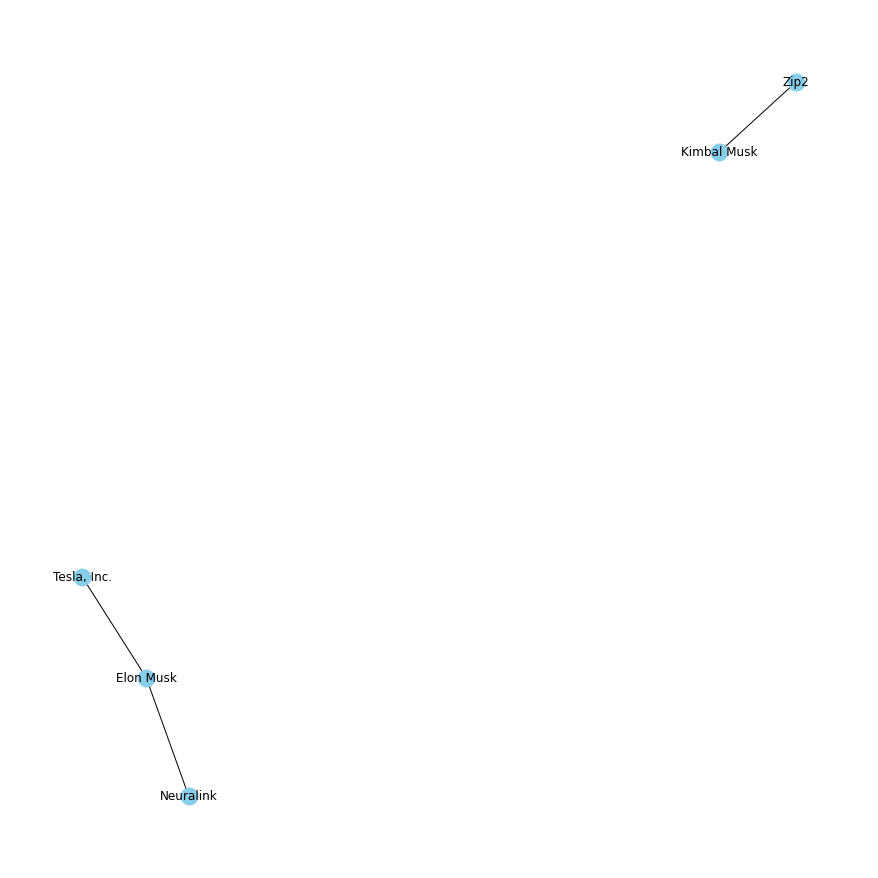

In [ ]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()